In [105]:
import pandas as pd
import lms_utilities as lms
import os
import matplotlib

# removes decimal places from float datatype
pd.options.display.float_format = '{:,.0f}'.format

In [106]:
# set the directory path for the output files from google classroom extractor
csv_path = os.path.join("..", "google-classroom-extractor", "data", "ed-fi-udm-lms")

In [107]:
# pull user data into a dataframe
users_df = lms.get_all_users(csv_path)

# pull section data into a dataframe
sections_df = lms.get_all_sections(csv_path)

# pull assignment data into a dataframe
assignments_df = lms.get_all_assignments(csv_path, sections_df)

# pull submission data into a dataframe
submissions_df = lms.get_all_submissions(csv_path, assignments_df)

In [108]:
# merge user and submission data
user_submissions_df = pd.DataFrame()
user_submissions_df = pd.merge(users_df, submissions_df, how='inner', left_on=('SourceSystemIdentifier','SourceSystem'), right_on=('LMSSourceSystemUserIdentifier','SourceSystem'))

In [109]:
# add user columns to submission count dataframe
submission_counts_df = pd.DataFrame()
submission_counts_df = user_submissions_df[["Name","EmailAddress"]]

# drop duplicate rows
submission_counts_df = submission_counts_df.drop_duplicates()

# rename column headings
submission_counts_df = submission_counts_df.rename({"Name":"Student Name","EmailAddress":"Email Address"}, axis='columns')

# set email address as the index
submission_counts_df = submission_counts_df.set_index('Email Address')

In [110]:
# pull unique submission status values to a list
submission_status = user_submissions_df['SubmissionStatus'].unique().tolist()

# add missing submissions count column
submission_counts_df["Missing"]=user_submissions_df.groupby('EmailAddress').AssignmentSourceSystemIdentifier.count()-user_submissions_df.groupby('EmailAddress').SubmissionStatus.count()

# loop through each submission status value and add a column with a count for each student
for index in range(len(submission_status)):
    submission_counts_df[submission_status[index]]=user_submissions_df[user_submissions_df.SubmissionStatus == submission_status[index]].groupby('EmailAddress').SubmissionStatus.count()

# replace NaN count values with 0
submission_counts_df.fillna(0, inplace=True)

# add total submissions count column
submission_counts_df["Total Submissions"]=user_submissions_df.groupby('EmailAddress').SubmissionStatus.count()

# format column headings to camel case
submission_counts_df.columns = submission_counts_df.columns.str.title()

In [111]:
# output dataframe
submission_counts_df

,Student Name,Missing,Created,Returned,Turned_In,Total Submissions
Email Address,,,,,,
roland.phillips@studentgps.org,Roland Phillips,0,2,1,0,3
peter.nash@studentgps.org,Peter Nash,0,2,1,0,3
larry.mahoney@studentgps.org,Larry Mahoney,0,2,1,0,3
kyle.hughes@studentgps.org,Kyle Hughes,0,2,2,1,5
mary.archer@studentgps.org,Mary Archer,0,1,3,1,5
micheal.turner@studentgps.org,Micheal Turner,0,1,1,0,2
stephen.caldwell@studentgps.org,Stephen Caldwell,0,0,1,1,2
olivia.hardy@studentgps.org,Olivia Hardy,0,0,2,0,2


Text(0, 0.5, 'Submission Counts by Status')

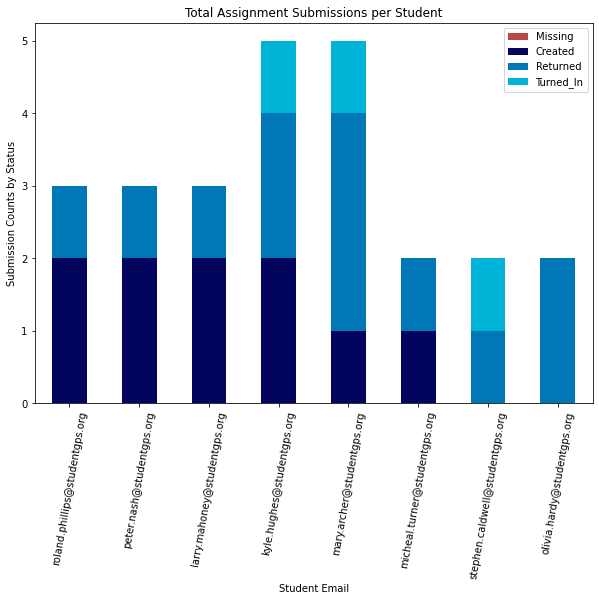

In [116]:
# set color palette for stacked bar chart
colors = ["#bc4749","#03045E","#0077B6","#00B4D8"]

# define bar plot input and format
submission_counts_plot = submission_counts_df.iloc[:,1:len(submission_status)+2].plot.bar(stacked=True, color=colors, figsize=(10,7), rot=80)

# set title and axis labels
submission_counts_plot.set_title("Total Assignment Submissions per Student")
submission_counts_plot.set_xlabel("Student Email")
submission_counts_plot.set_ylabel("Submission Counts by Status")